In [14]:
import qualified Control.Monad.Bayes.Sampler.Lazy as Lazy
import qualified Control.Monad.Bayes.Inference.Lazy.MH as Lazy

import Control.Monad.Bayes.Class
import qualified Data.Text as T
import Numeric.Log
import Control.Arrow (first, second)
import Statistics.Distribution
import qualified Statistics.Distribution.Poisson as S
import Control.Monad.Bayes.Enumerator


:l Plotting.hs


# Lazy Sampling

The sampler defined in `Control.Monad.Bayes.Sampler.Strict` fares poorly with infinite data structures. For example, `finiteList` defined below is a distribution over a small finite set, but because it is defined as the marginal of an infinite list, running it with a strict sampling monad will not terminate.

In [15]:
finiteList :: MonadDistribution m => m [Double]
finiteList = do
    infiniteList <- sequence $ repeat random
    return (take 3 infiniteList)

One solution is to use a streaming library, such as `pipes`, and indeed this proves useful in many situations. But another is to define a lazy sampler, which is the approach taken by [LazyPPL](https://lazyppl.bitbucket.io/). 

In [16]:
Lazy.sample finiteList

[0.8180766766189881,0.344956911022809,2.3083124243546638e-2]

`Control.Monad.Bayes.Sampler.Lazy` is simply a port of LazyPPL, with some refactoring. In particular, what LazyPPL calls the `Prob` monad, we now call `Sampler`, and `Meas` is built modularly as `Weighted Sampler`. 

LazyPPL also comes with a number of inference algorithms that make special use of the sampler's laziness, including weighted importance sampling and Metropolis-Hastings. Monad-Bayes has these also, as shown below:

In [17]:
model :: MonadMeasure m => m Bool
model = do
  -- Prior belief: it is Sunday with prob. 1/7
  sunday <- bernoulli (1/7)
  -- I know the rates of buses on the different days:
  let rate = if sunday then 3 else 10 
  -- observe 4 buses
  factor $ Exp $ logProbability (S.poisson rate) 4
  -- score $ poissonPdf rate 4
  return sunday

In [19]:
xws <- Lazy.mh 1 model

: 

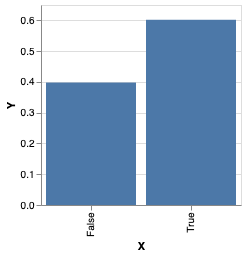

In [34]:
plotVega $ first (T.pack . show) <$> toEmpirical (take 1000 $ fst <$> xws)

In [20]:
x = bernoulli 0.5

y <- Lazy.sample x
take 4 y

[1,2,3,4]

In [10]:
variance = 1
import Diagrams.Prelude (V2(..))
import Control.Monad.Loops
import Control.Monad


-- kernel :: MonadDistribution m => V2 Real -> Distribution (V2 Real)
kernel (V2 x y) = do
    newX <- normal (x+0.5) variance
    newY <- normal (y+0.5) variance
    return (V2 newX newY)

-- randomWalk :: Distribution [V2 Double]
randomWalk = unfoldrM (fmap (Just . (\x -> (x,x))) . kernel) 0


x <- Lazy.sample randomWalk

take 4 x

[V2 (-0.33752627641182276) 0.6879027115791256,V2 0.5479956320453119 2.1371803404562364,V2 0.5573120317335094 1.7091817011312638,V2 0.9797529388677747 3.7490921318570587]

In [29]:
observations = mapM (\(V2 x y) -> 
    do
        x' <- normal x 2
        y' <- normal y 2
        return (V2 x' y')) =<< randomWalk


In [38]:
obs <- Lazy.sample observations
take 4 x

[V2 3.359606220496155 0.28261234040449634,V2 (-4.010679323774817) 0.6391189243868503,V2 1.4470509903824165 0.6840265398936514,V2 0.6074621050753484 6.120654529217177]

In [ ]:
import Control.Applicative
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Inference.SMC
import Control.Monad.Bayes.Population


-- -- conditioning :: (MonadDistribution m, MonadCond m) => P.Producer (Double,Double) m ()
-- conditioning = do
--     walk <- randomWalk
--     forM_ (zip walk obs) (\(V2 x y, V2 x' y') -> 
--         factor 0.1)
--     return walk

-- x <- Lazy.sample $ runPopulation $ smcMultinomial 4 4 $ conditioning
-- take 4 x
--     -- >-> P.map fst

Press Ctrl-C again to quit kernel.